In [1]:
import matplotlib.pyplot as plt
import numpy as np
from reservoirpy.nodes import Reservoir, Ridge
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

In [12]:
data = np.loadtxt("./lienard_intermittency.dat")

In [13]:
data.shape[0] / 100

500.0

In [30]:
train_parts = []
test_parts = []
for i in range(0, len(data), 500):
    train_parts.append(data[i:i+400, 1][..., None])
    test_parts.append(data[i+400:i+500, 1][..., None])    

In [5]:
def CalculateMatrices(train_parts, test_parts, plot_3d=False):
    all_matrices = []
    for i in range(1, 11):
        matrices = []
        for j in range(0, 100-i, i):
            X = train_parts[j:j+i]
            Y_train = []
            all_states = []
            for c in range(i):
                X_train = X[c][:-1]
                Y_train.append(X[c][1:])

                reservoir = Reservoir(200, lr=0.5, sr=0.9) 
                if plot_3d:
                    states = reservoir.run(X_train)
                    all_states.append(states)
                else:
                    states = reservoir.run(X_train[..., None])
                    all_states.append(states)


            readout = Ridge(ridge=1e-7, input_bias=False)
            states = np.concatenate(all_states)
            Y_train = np.concatenate(Y_train)
    #         print("states", states.shape)
    #         print("Y_train", Y_train.shape)

            if plot_3d:
                readout.fit(states, Y_train)
            else:
                readout.fit(states, Y_train[..., None])
                
            matrices.append(readout.params["Wout"])


            if j + 2 * i >= 100:
                

                if not plot_3d:
                    X_test = test_parts[-1][:-1][..., None]
                    Y_test = test_parts[-1][1:][..., None]
                    states = reservoir.run(X_test)
                    output = readout.run(states)
                    plt.figure(figsize=(16, 9))
                    plt.plot(Y_test)
                    plt.plot(output, linestyle = '--')
                else:
                    X_test = test_parts[-1][:-1]
                    Y_test = test_parts[-1][1:]
                    states = reservoir.run(X_test)
                    output = readout.run(states)
                    fig = plt.figure(figsize=(16, 9))
                    ax = fig.add_subplot(projection='3d')
                    ax.plot(Y_test[:, 0], Y_test[:, 1], Y_test[:, 2])
                    plt.plot(output[:, 0], output[:, 1], output[:, 2], linestyle = '--', alpha=0.35)
        all_matrices.append(matrices)
    return all_matrices

In [6]:
def CalculateDistance(v1, v2):
    return np.sqrt((v1 - v2)**2)

In [7]:
def CalculateMeanStd(all_matrices, frobenius=False):
    means = []
    stds = []
    for matrices in all_matrices:
        distances = []
        for index, matrix1 in enumerate(matrices):
            for matrix2 in matrices[index+1:]:
                distance = np.linalg.norm(matrix1 - matrix2) if frobenius else CalculateDistance(matrix1, matrix2)
                distances.append(distance)
        means.append(np.mean(distances))
        stds.append(np.std(distances))  
    return np.array(means), np.array(stds)

Running Reservoir-2104: 100%|███████████████████████████| 399/399 [00:00<00:00, 13699.81it/s]


Running Reservoir-2274: 100%|███████████████████████████| 399/399 [00:00<00:00, 13591.99it/s]


Running Reservoir-2444: 100%|███████████████████████████| 399/399 [00:00<00:00, 13621.53it/s]


Running Reservoir-2614: 100%|███████████████████████████| 399/399 [00:00<00:00, 13405.27it/s]


Running Reservoir-2786: 100%|███████████████████████████| 399/399 [00:00<00:00, 13470.66it/s]


Running Ridge-857: 100%|██████████████████████████████████| 99/99 [00:00<00:00, 42931.77it/s]


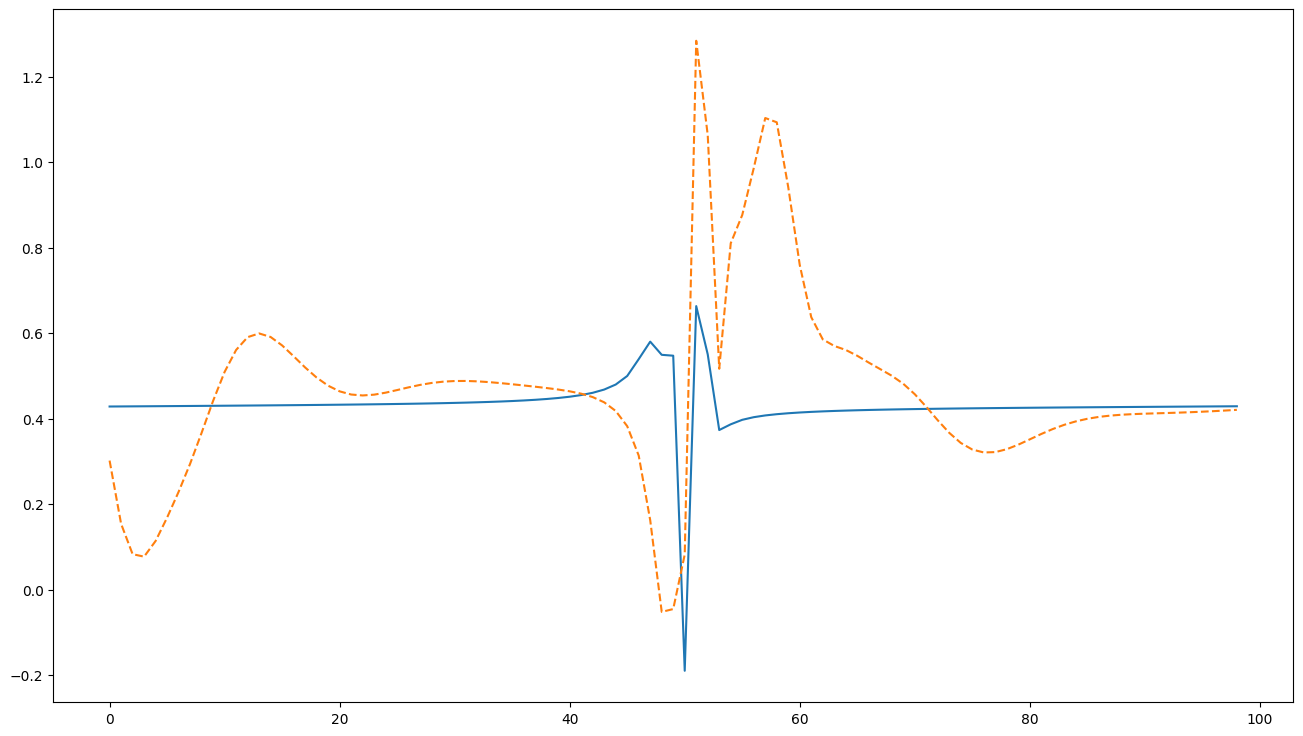

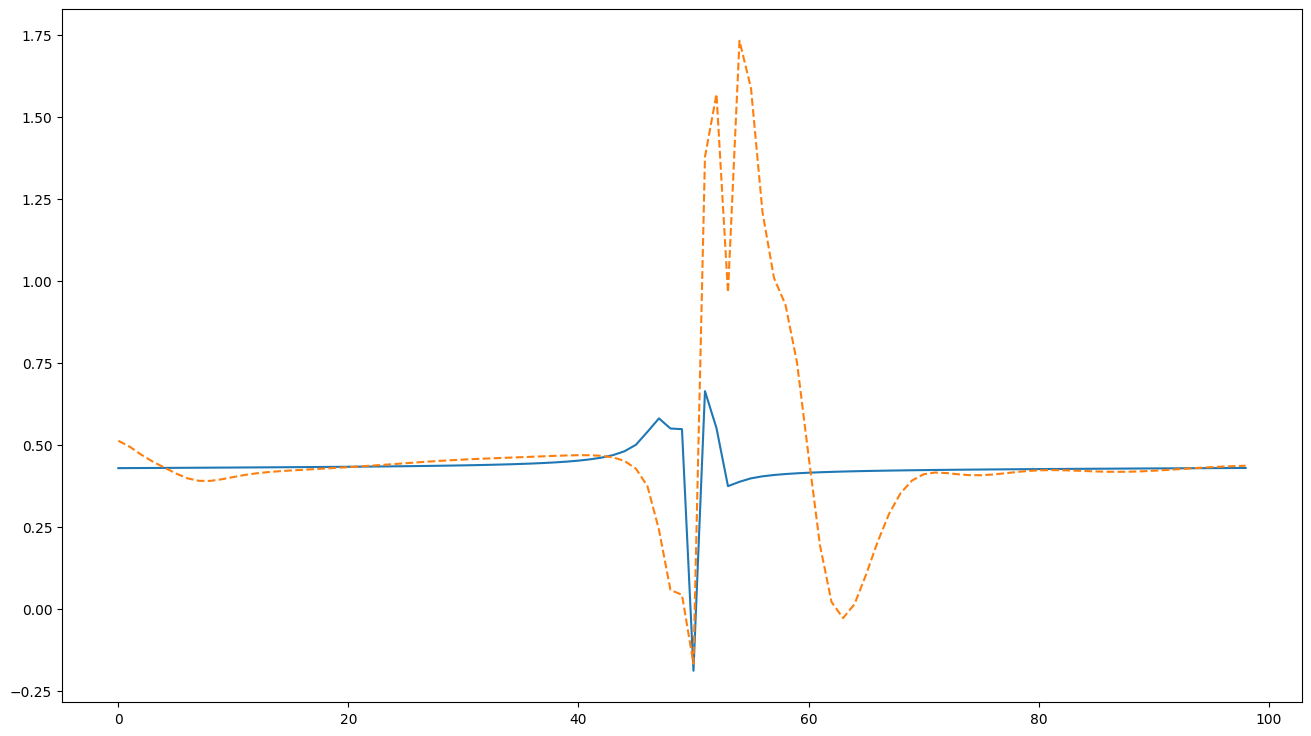

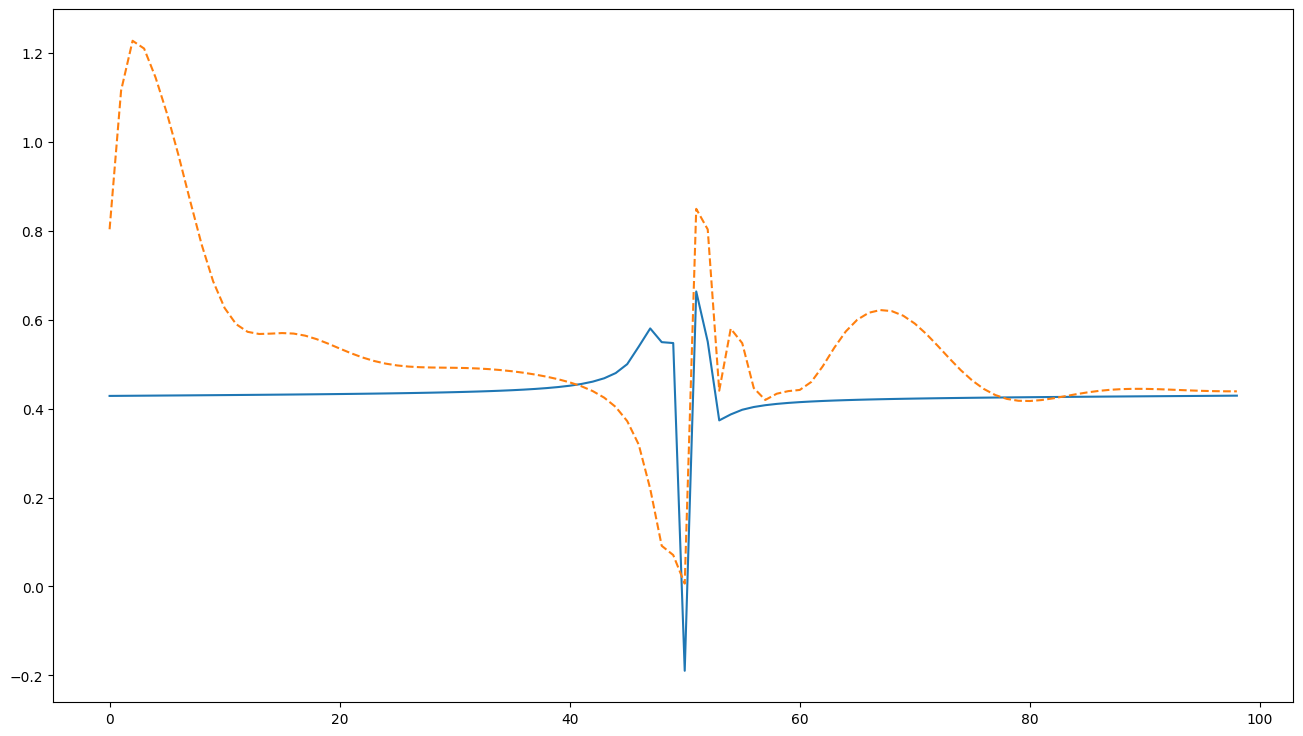

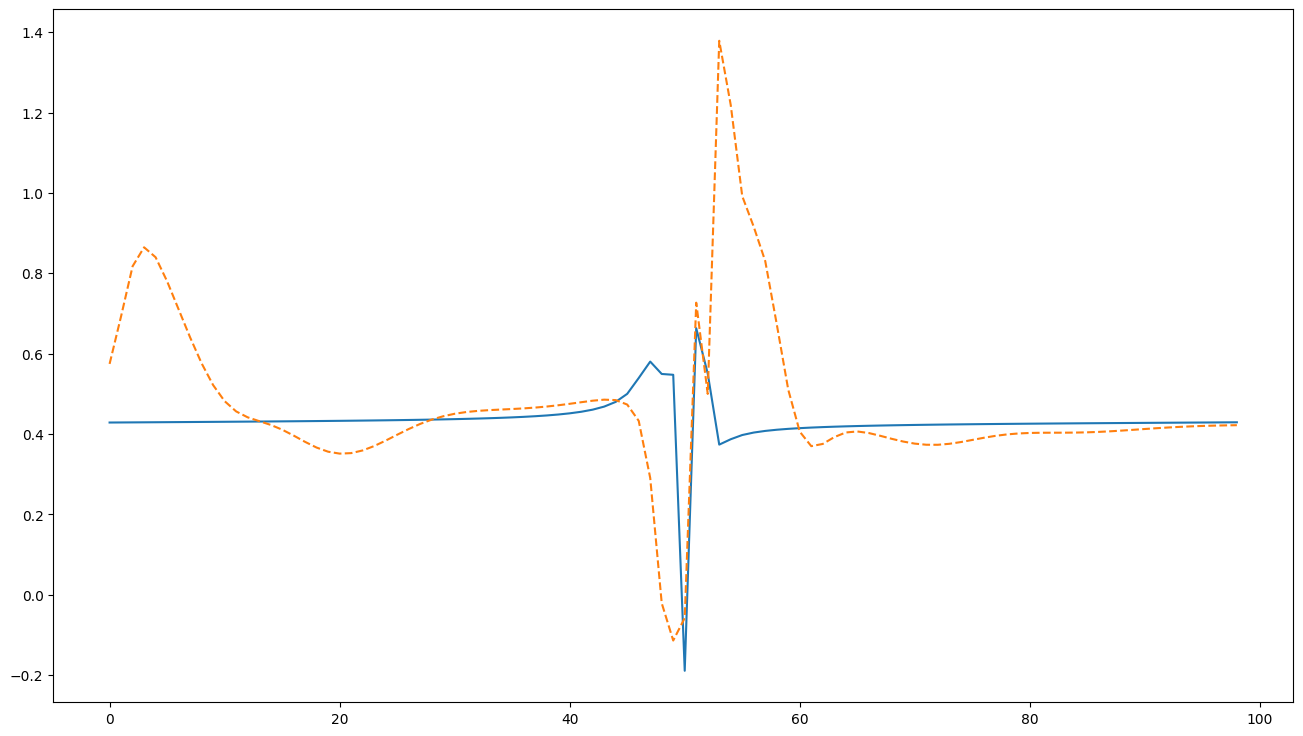

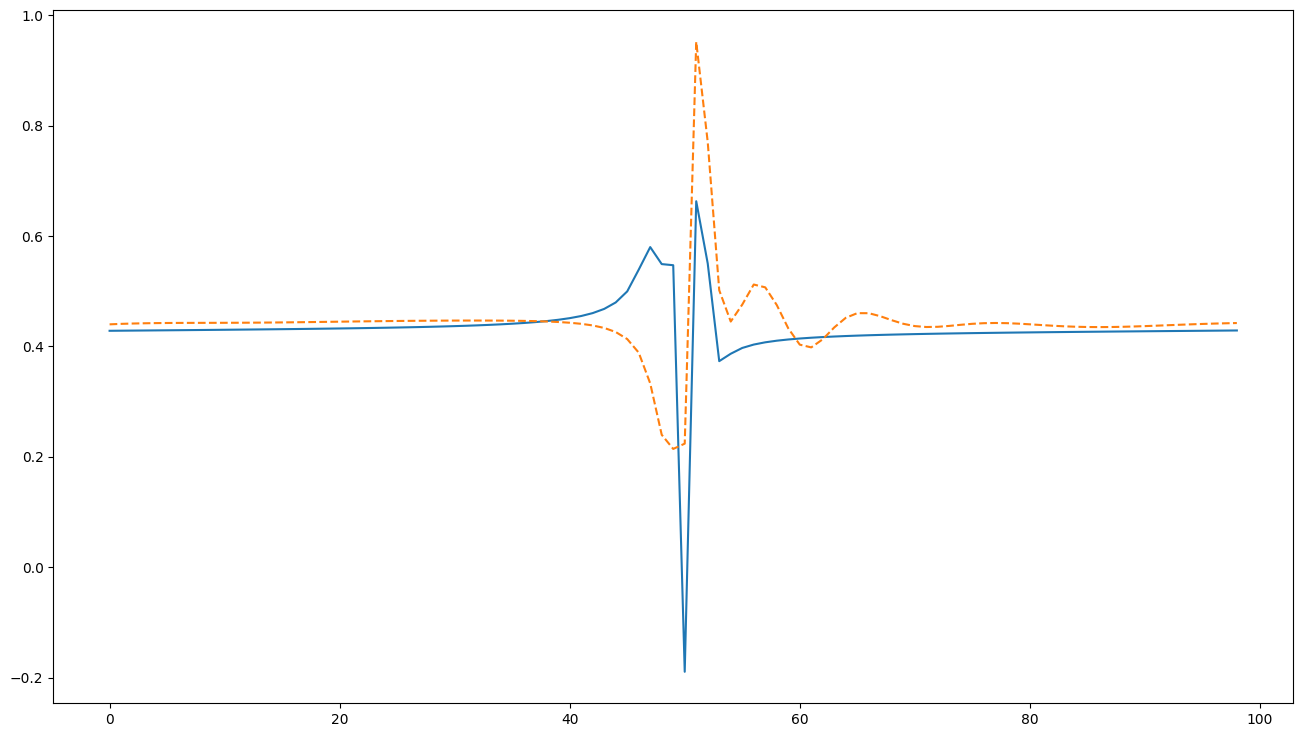

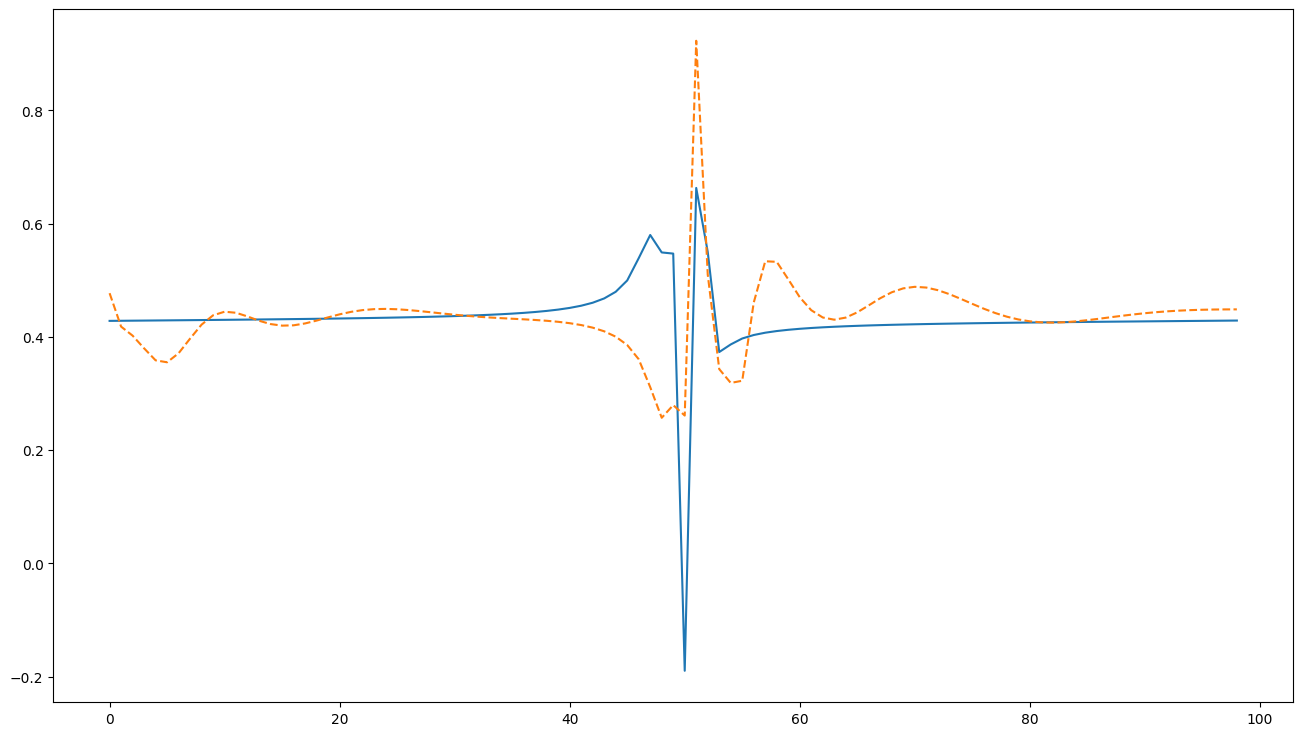

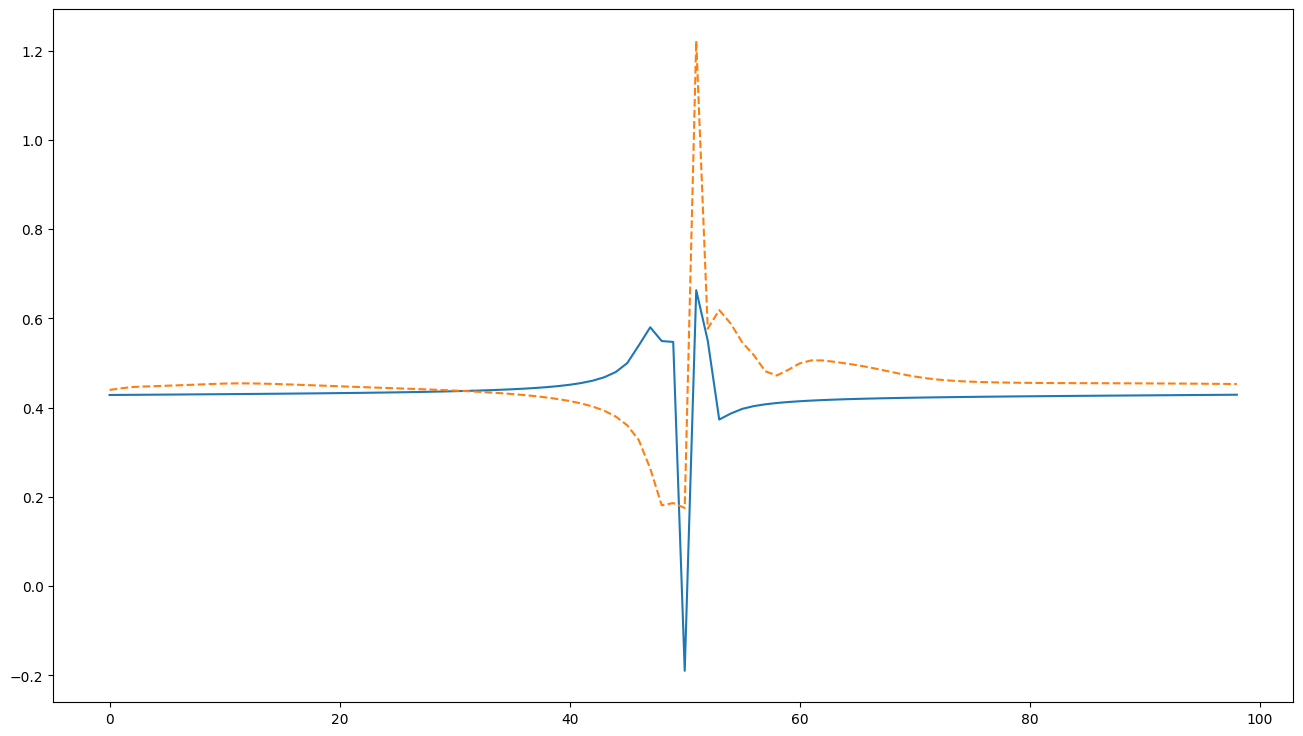

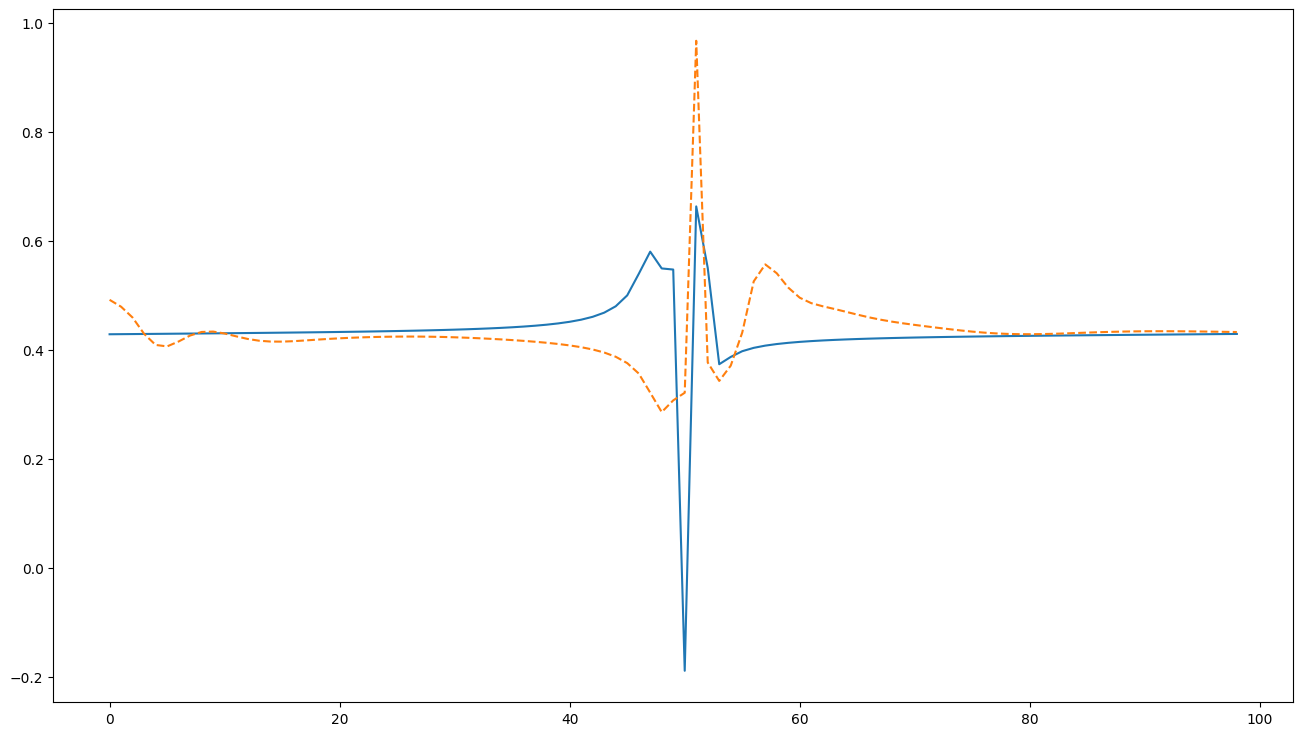

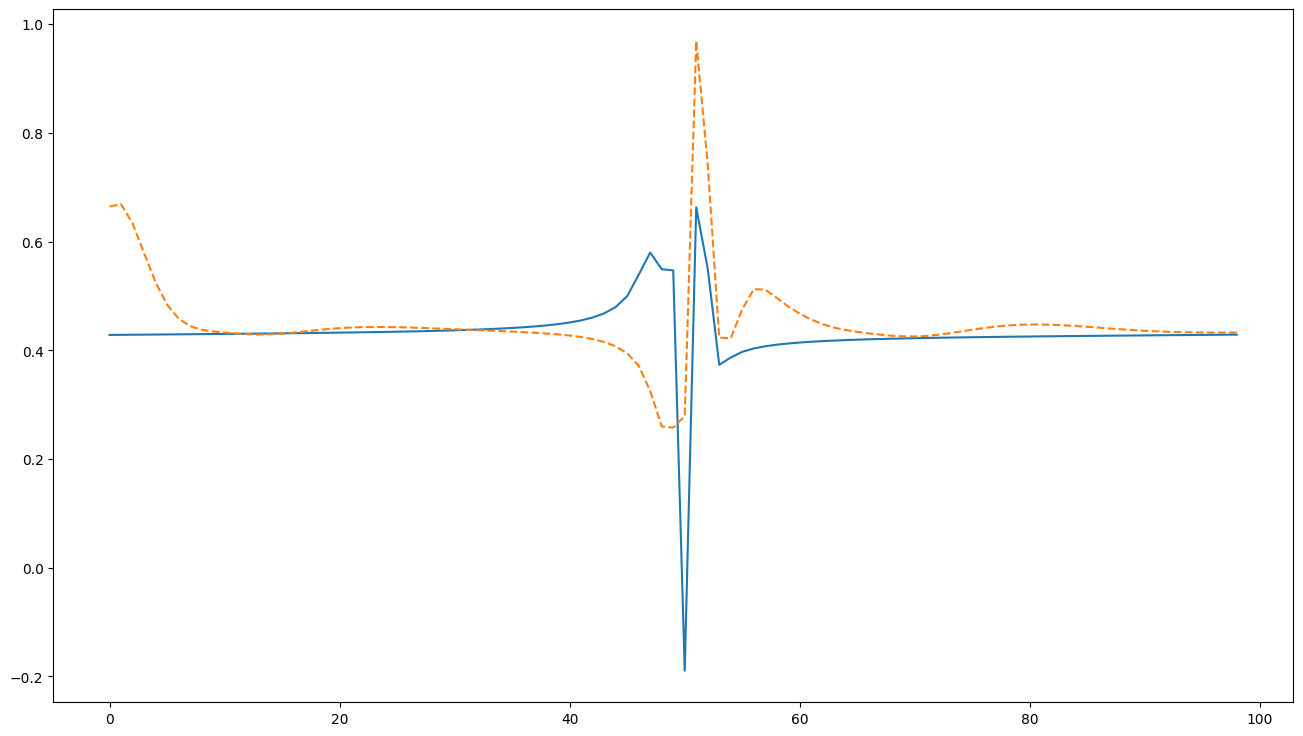

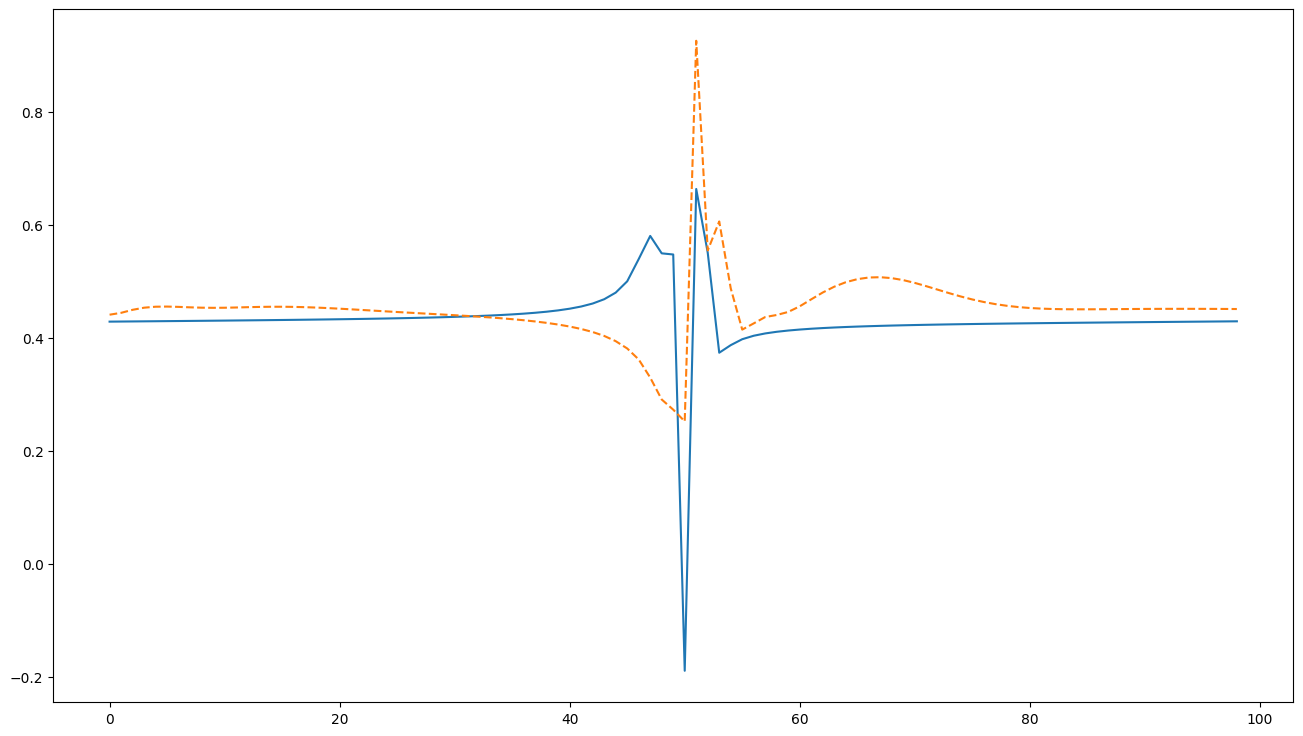

In [34]:
all_matrices = CalculateMatrices(train_parts, test_parts)

In [36]:
means, stds = CalculateMeanStd(all_matrices)

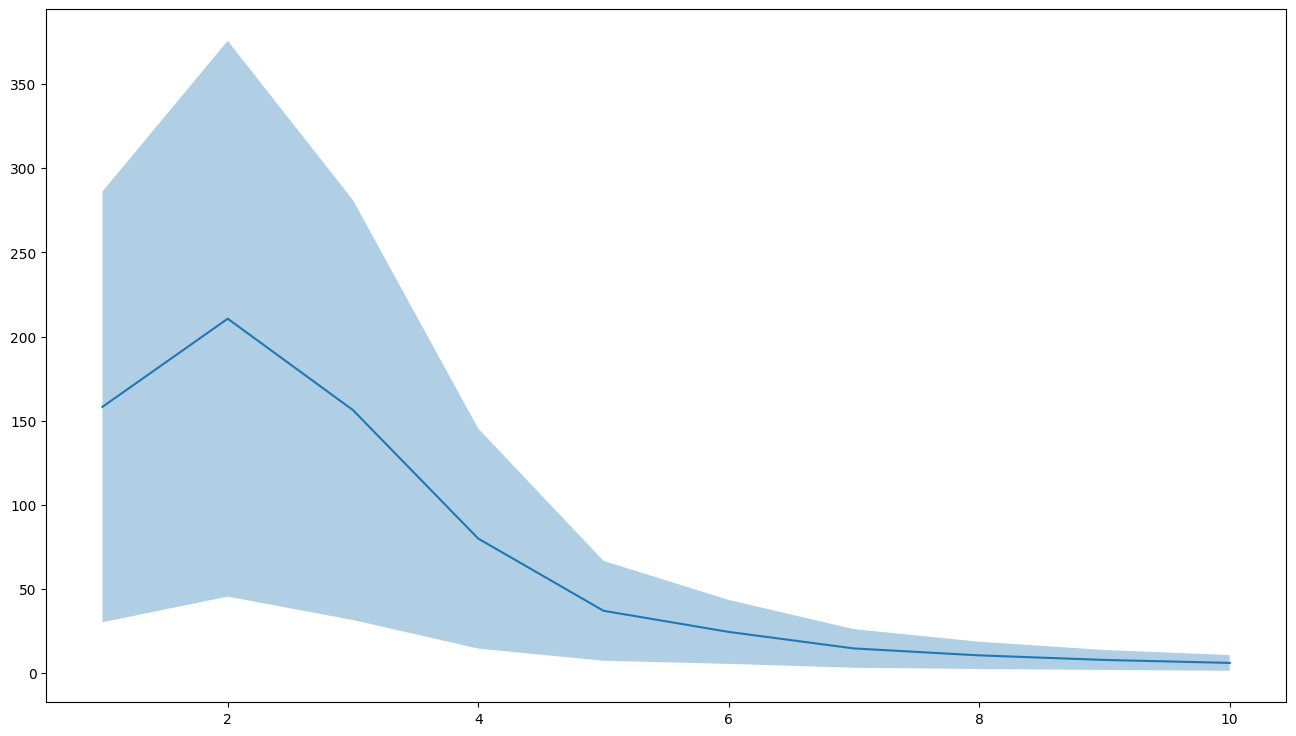

In [37]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(1, 11), means)
plt.fill_between(np.arange(1, 11), means - stds, means + stds, alpha=0.35)

# Rossler system

In [2]:
a = b = 0.2
c = 5.7
def Rossler(t, X):
    x, y, z = X
    return [- y - z,
            x + a * y,
            b + z * (x - c)]

In [6]:
sol = solve_ivp(Rossler, [0, 1000], 
                    [np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1)], 
                    t_eval=np.arange(0, 1000, 0.1), rtol = 1e-11, atol = 1e-11, dense_output=True)

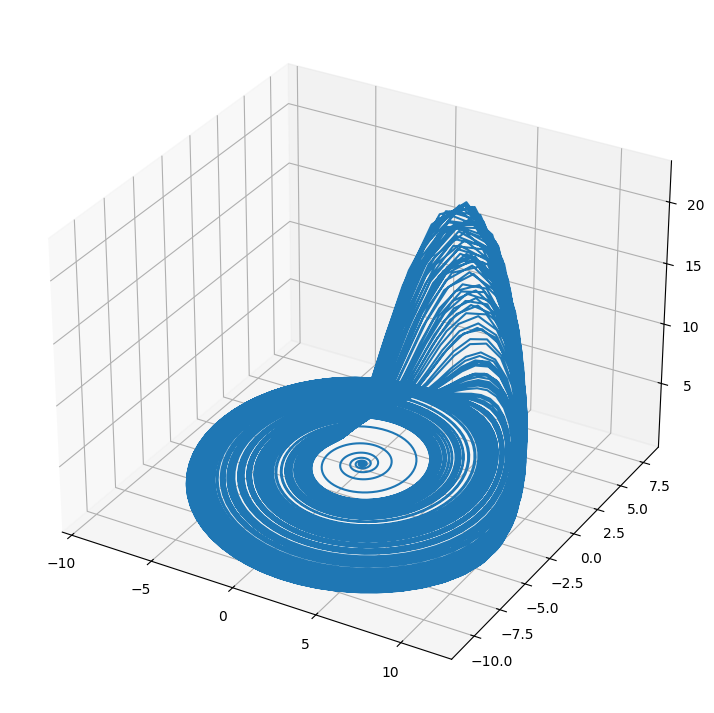

In [7]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

In [6]:
trajectorys = []
np.random.seed(42)
for i in tqdm(range(100)):
    sol = solve_ivp(Rossler, [0, 10000], 
                    [np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1), np.random.uniform(-0.1, 0.1)], 
                    t_eval=np.arange(0, 10000, 0.1), rtol = 1e-11, atol = 1e-11, dense_output=True)
    trajectorys.append(sol.y)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

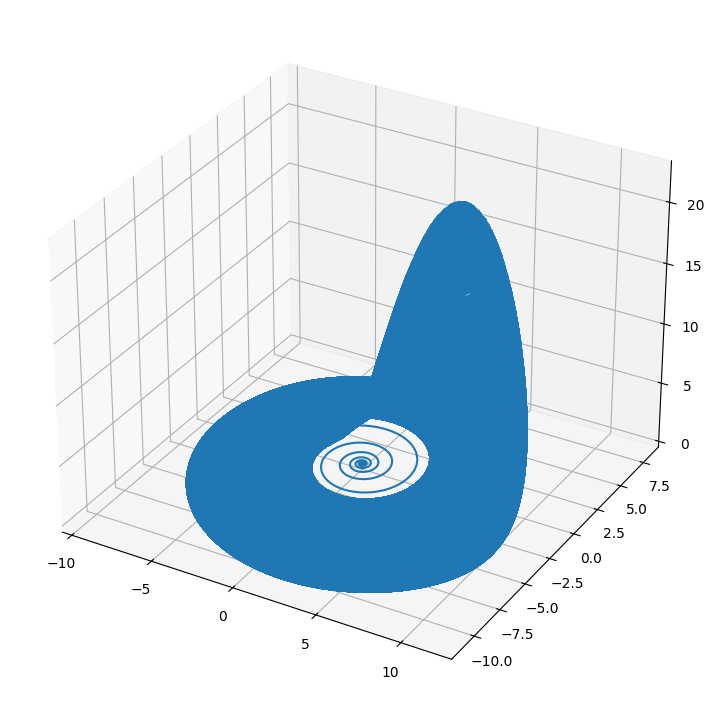

In [7]:
for i in range(100):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(projection='3d')
    ax.plot(trajectorys[i][0], trajectorys[i][1], trajectorys[i][2])
    plt.savefig("figures/rossler100000points0_1Step" + str(i))
    plt.close()

In [8]:
for i in range(100):
    np.save("data/rossler100000points0_1Step"+str(i), trajectorys[i])

In [4]:
trajectorys = []
for i in range(100):
    trajectorys.append(np.load("data/rossler0_1Step"+str(i) + ".npy"))

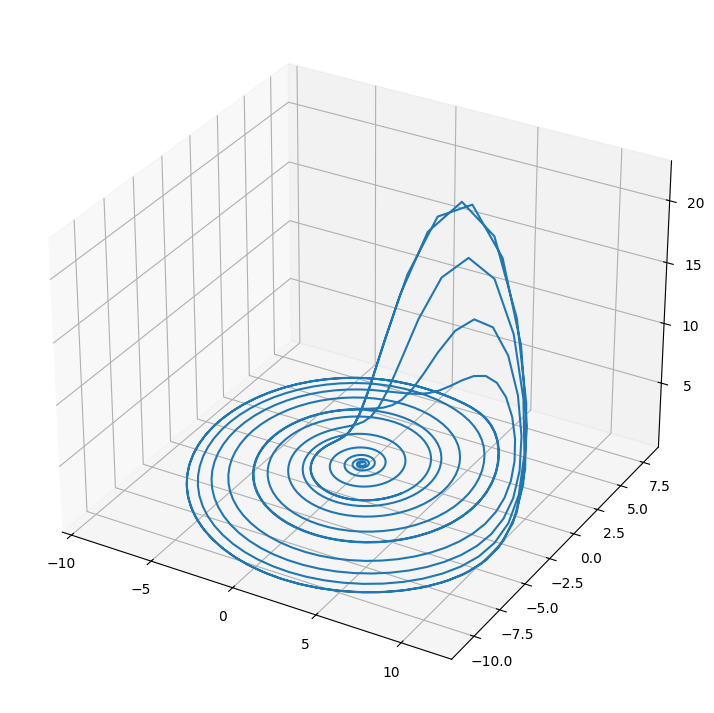

In [5]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(trajectorys[0][0][:1000], trajectorys[0][1][:1000], trajectorys[0][2][:1000])

## Only x

In [11]:
train_parts = []
test_parts = []
for trajectory in trajectorys:
    train_parts.append(trajectory[0, :8000])
    test_parts.append(trajectory[0, 8000:])    

Running Reservoir-1115: 100%|██████████████████████████████████████| 7999/7999 [00:00<00:00, 13970.18it/s]


Running Reservoir-1263: 100%|██████████████████████████████████████| 7999/7999 [00:00<00:00, 13958.84it/s]


Running Reservoir-1413: 100%|██████████████████████████████████████| 7999/7999 [00:00<00:00, 14015.33it/s]


Running Reservoir-1561: 100%|██████████████████████████████████████| 7999/7999 [00:00<00:00, 13682.64it/s]


Running Reservoir-1711: 100%|██████████████████████████████████████| 7999/7999 [00:00<00:00, 14077.57it/s]


Running Reservoir-1859: 100%|██████████████████████████████████████| 7999/7999 [00:00<00:00, 13788.11it/s]


Running Ridge-571: 100%|███████████████████████████████████████████| 1999/1999 [00:00<00:00, 49626.01it/s]


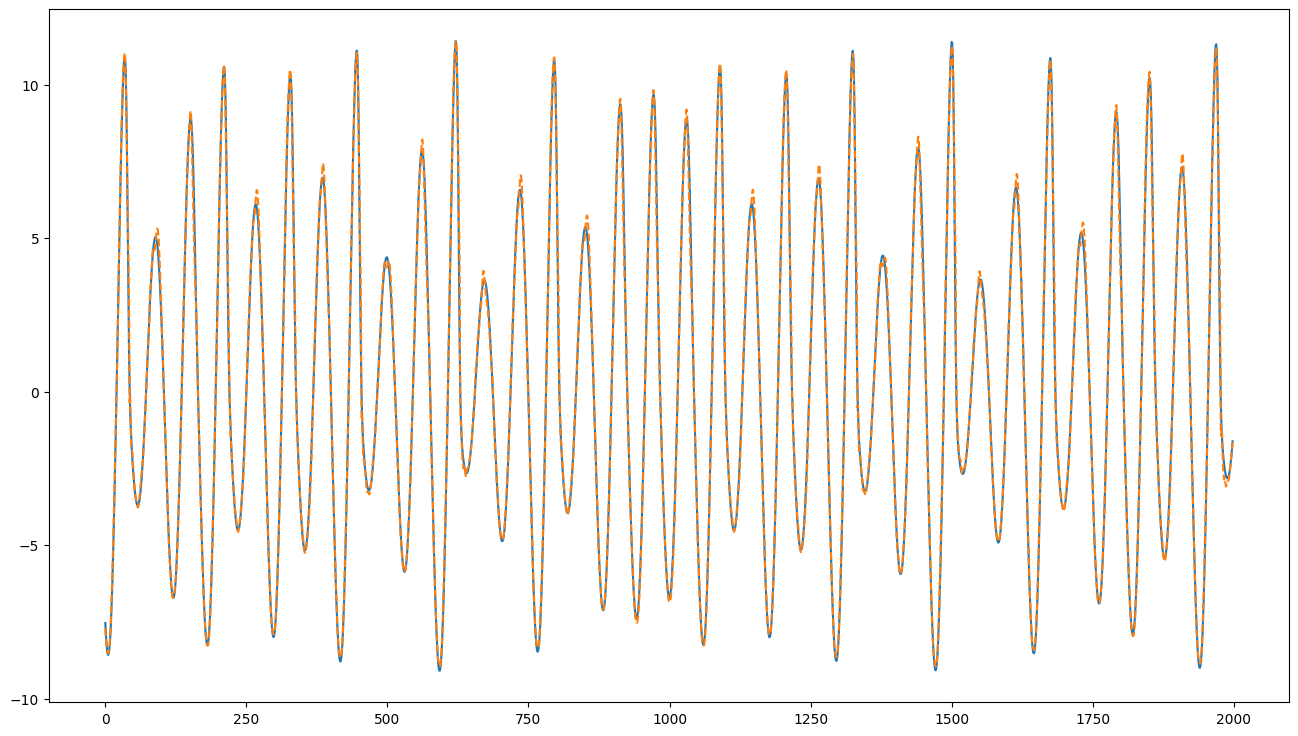

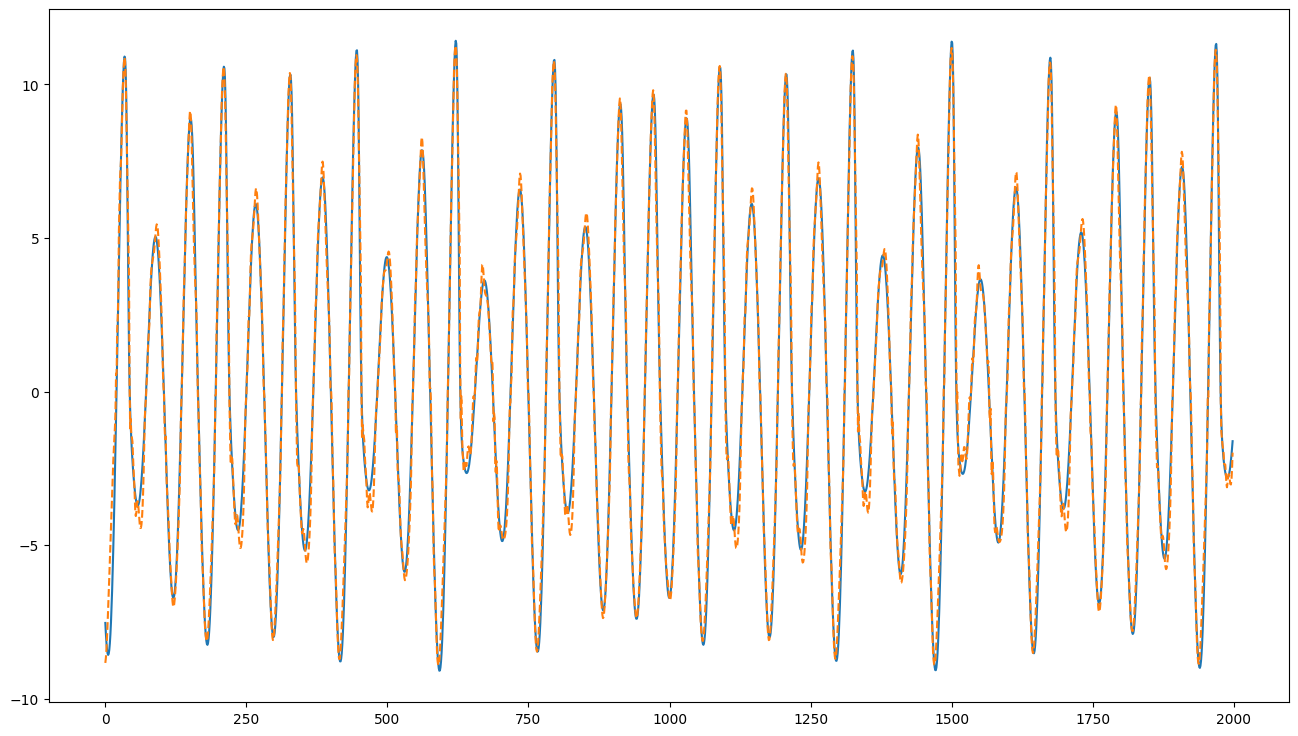

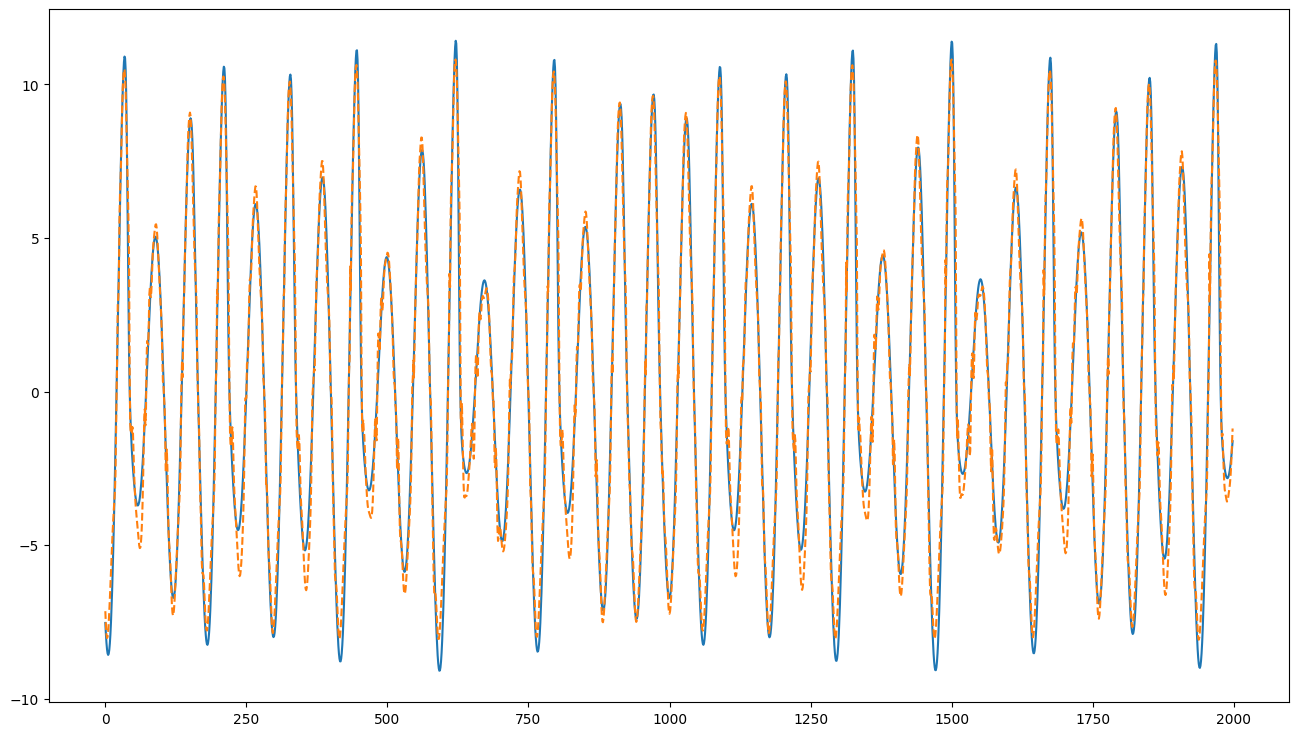

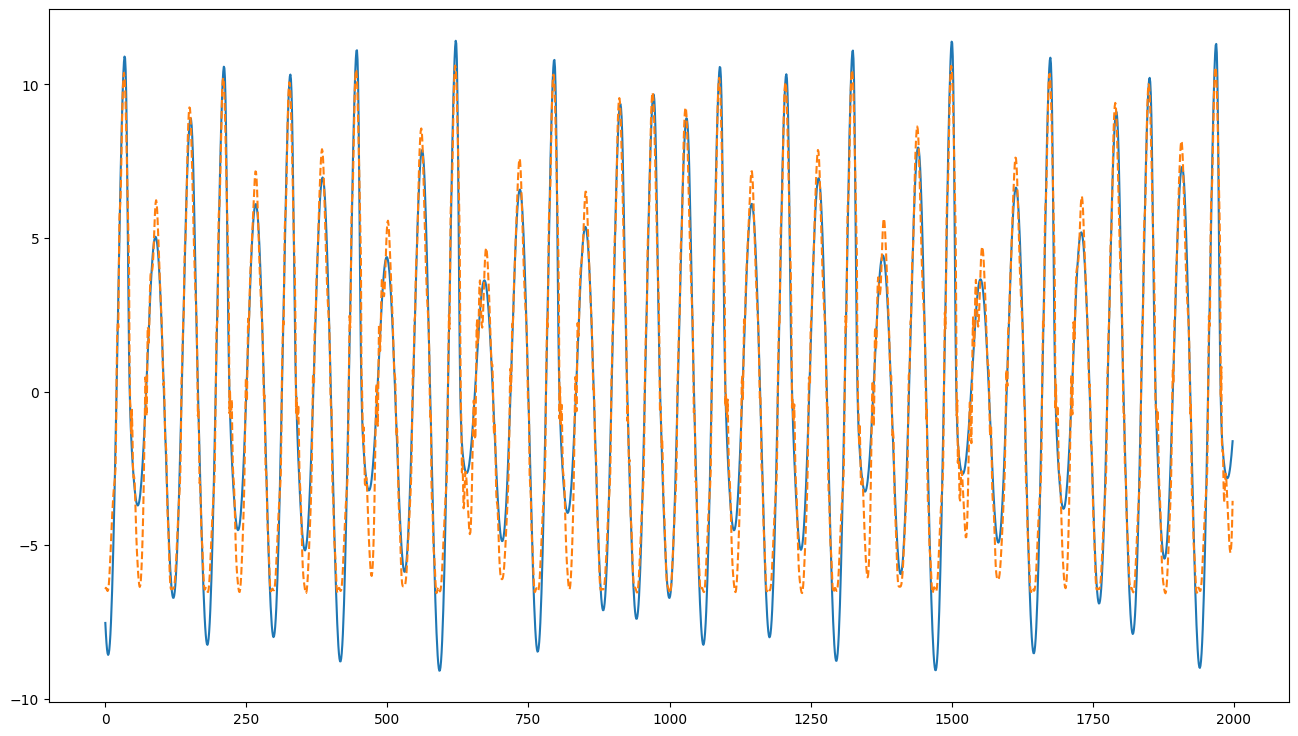

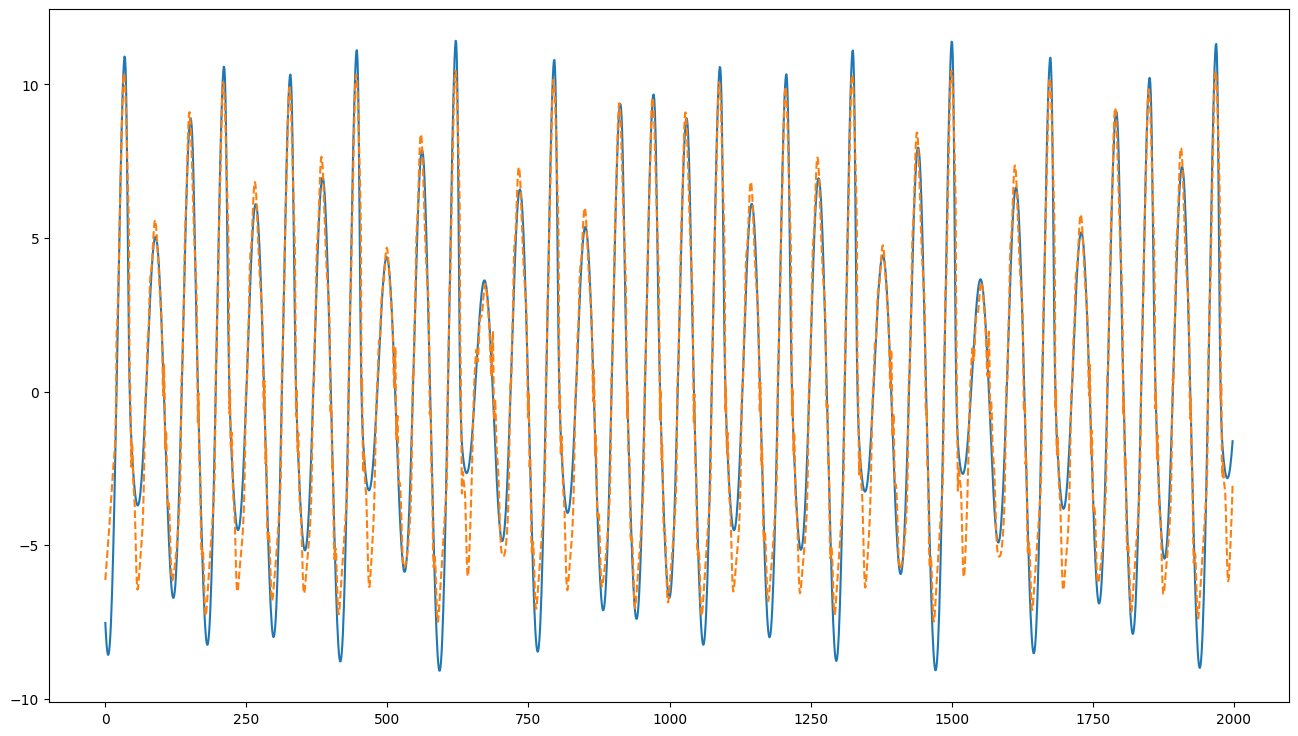

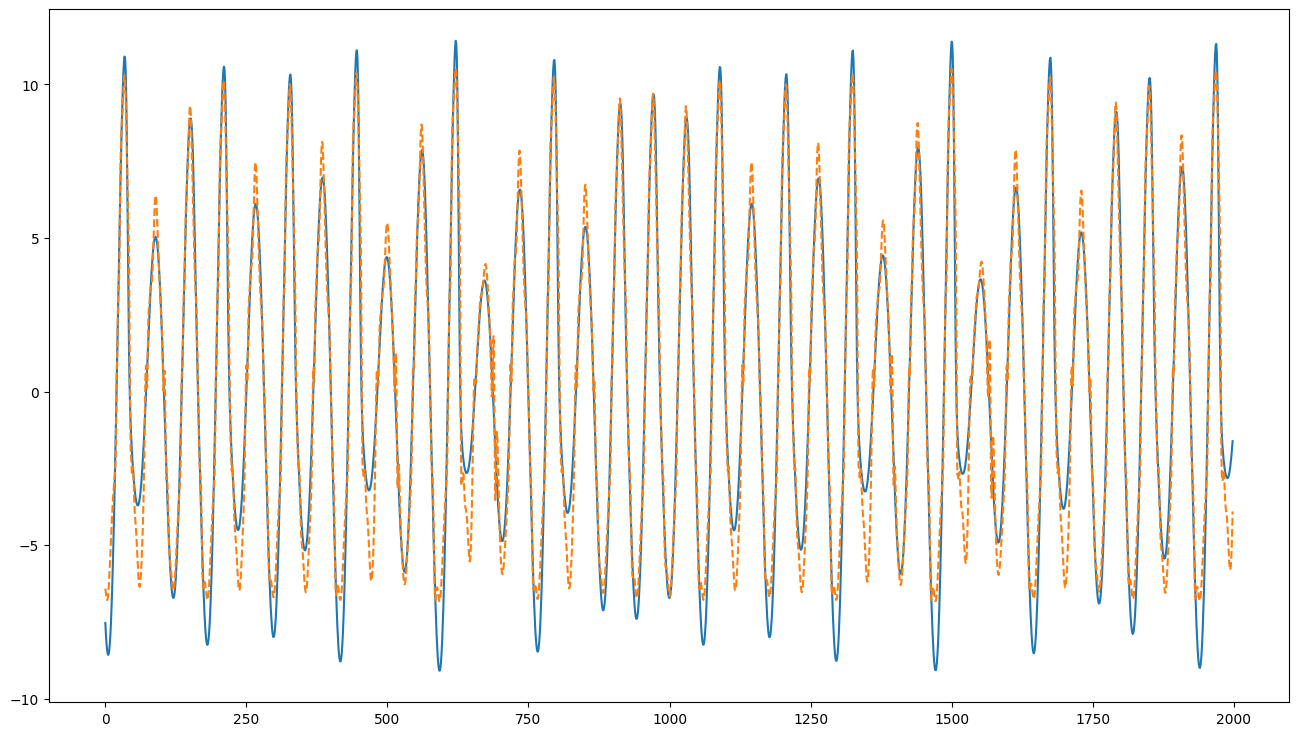

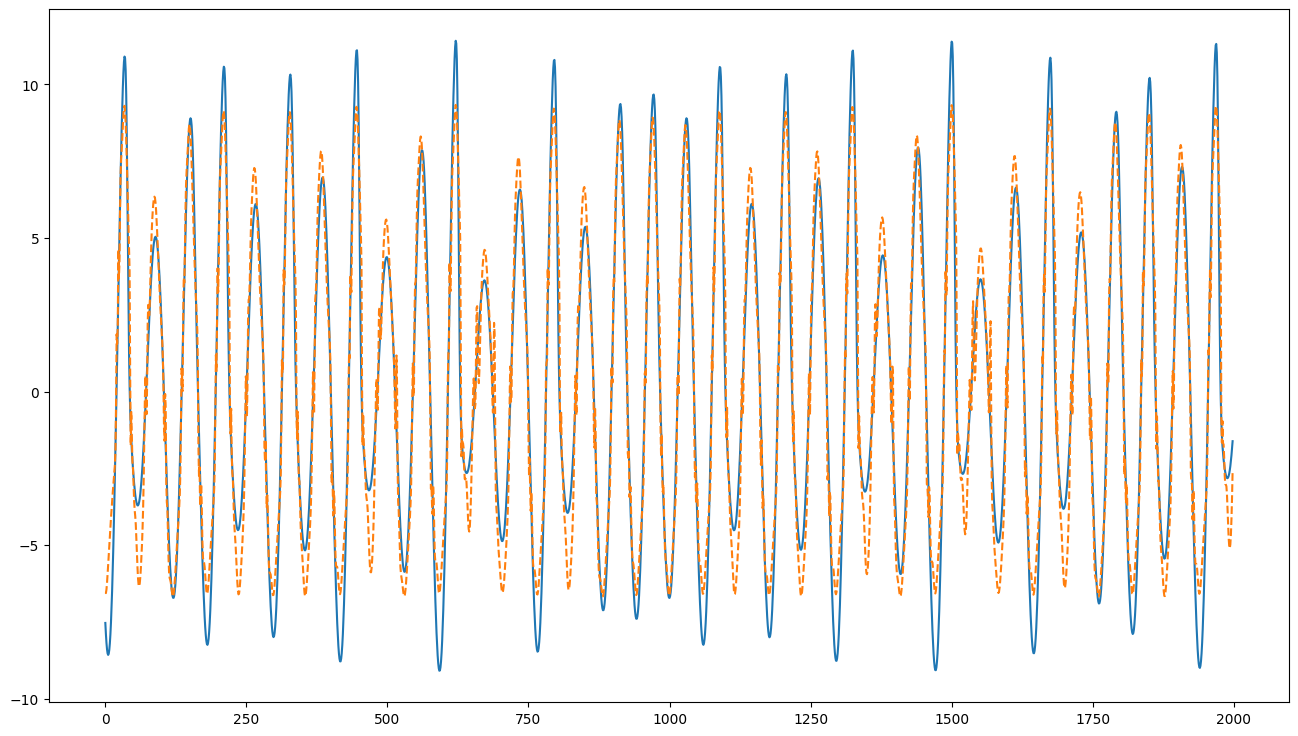

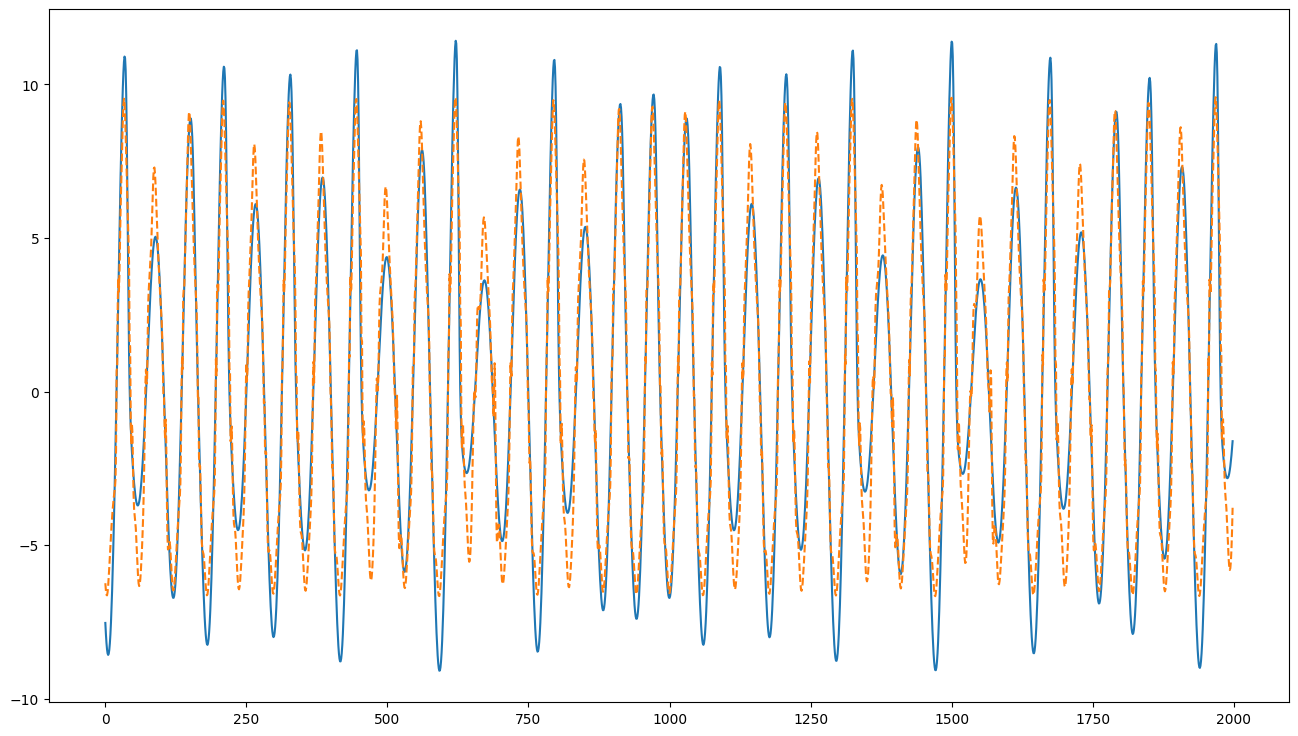

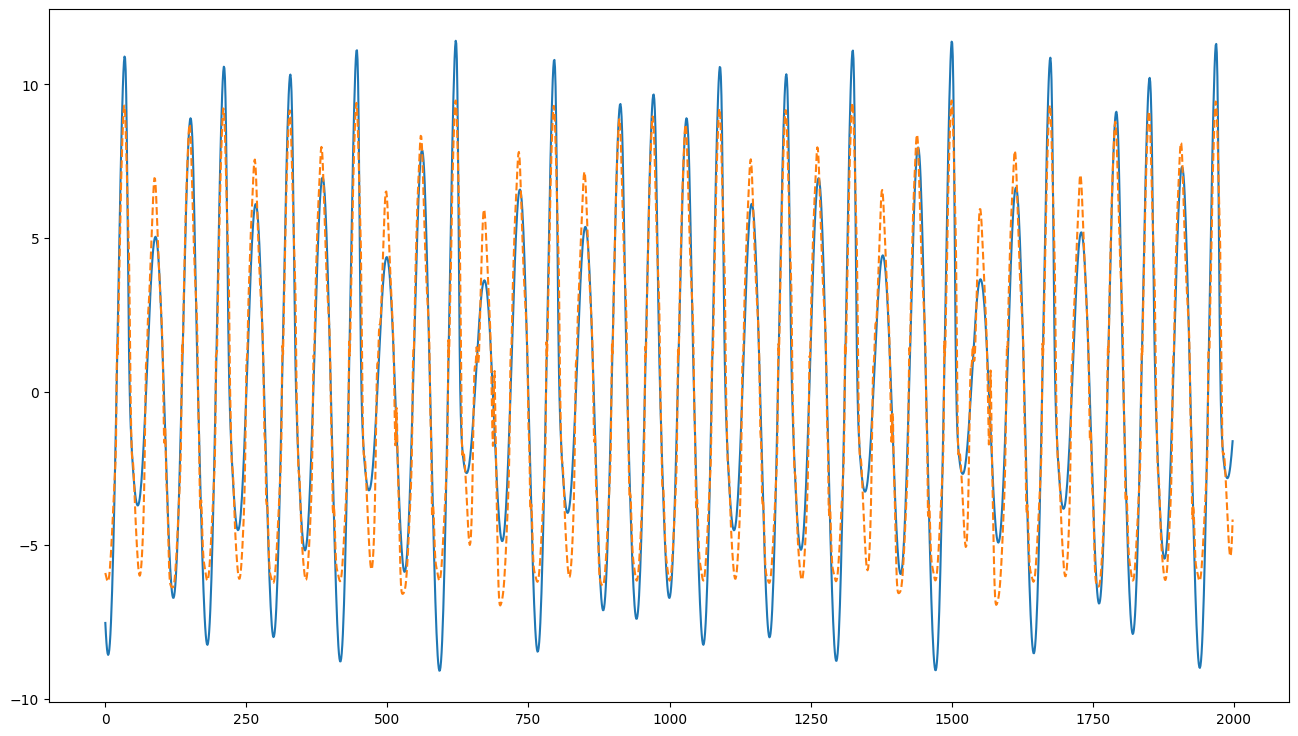

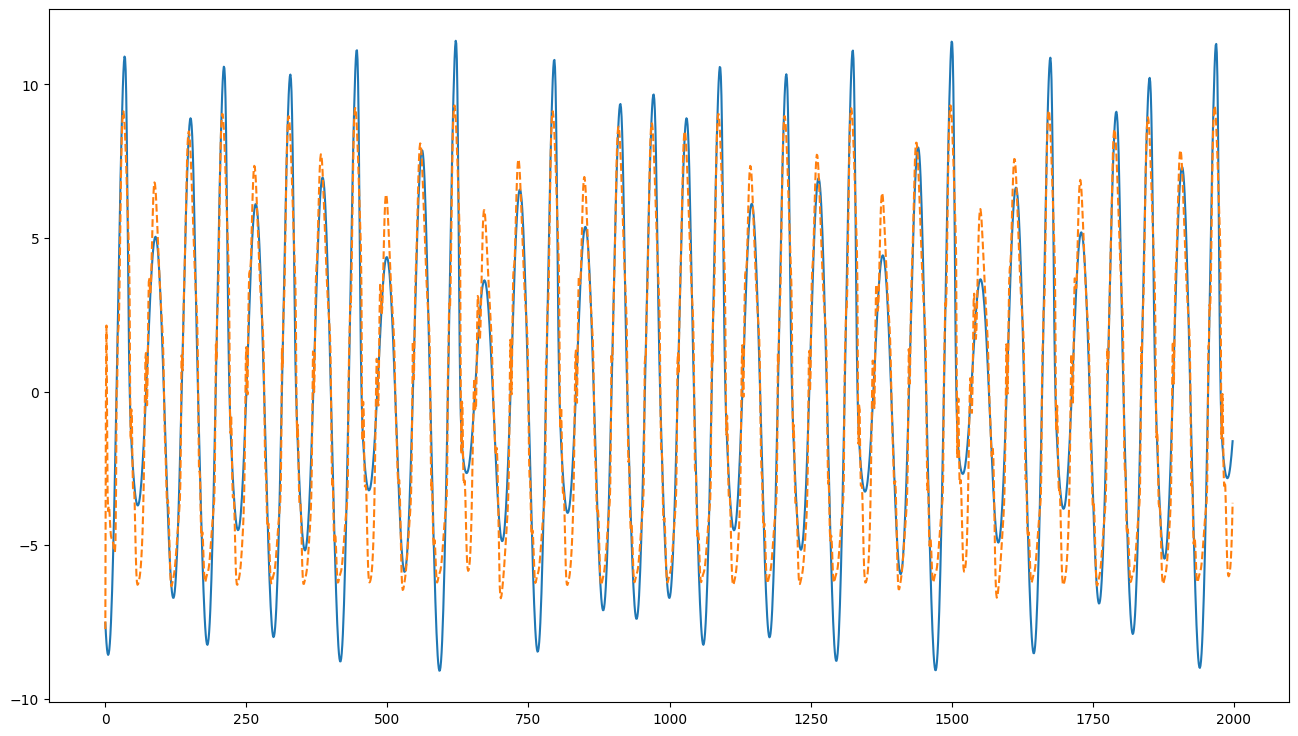

In [12]:
all_matrices = CalculateMatrices(train_parts, test_parts)

In [13]:
means, stds = CalculateMeanStd(all_matrices)

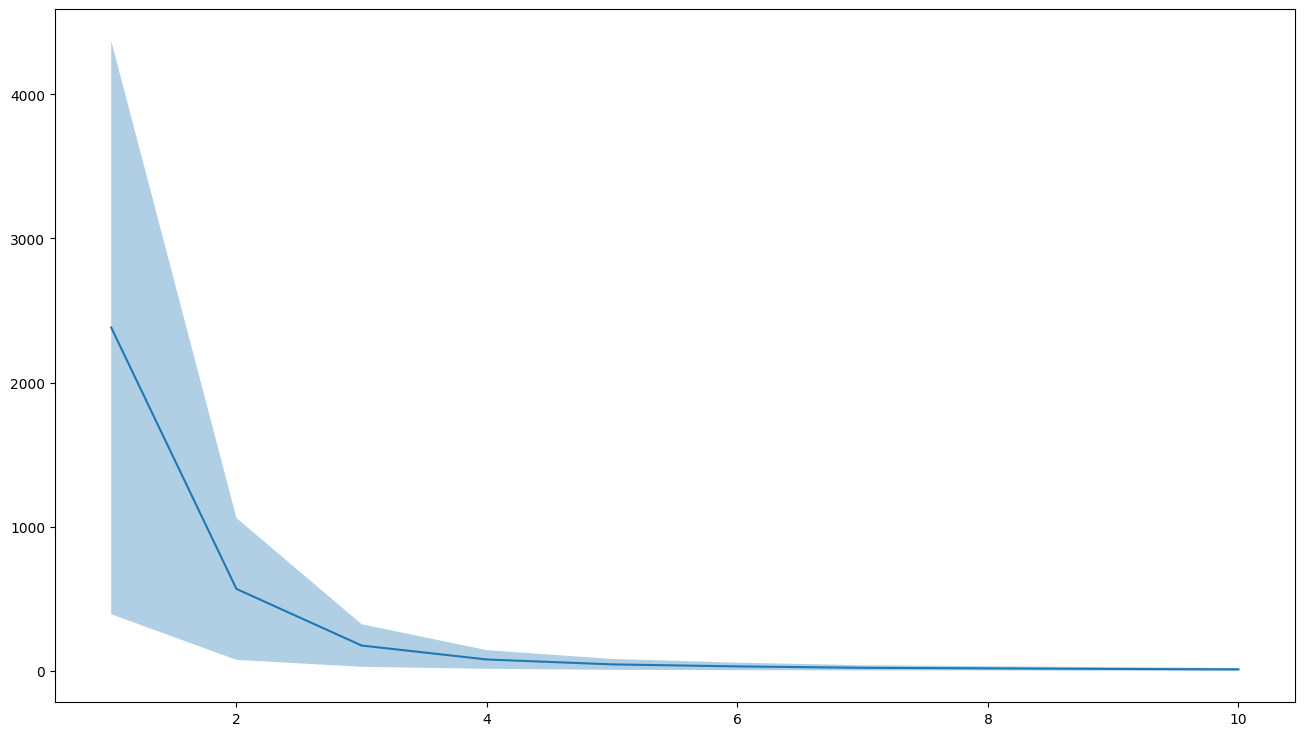

In [14]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(1, 11), means)
plt.fill_between(np.arange(1, 11), means - stds, means + stds, alpha=0.35)

## Full system

In [3]:
train_parts = []
test_parts = []
for trajectory in trajectorys:
    train_parts.append(trajectory[:, :8000].T)
    test_parts.append(trajectory[:, 8000:].T)    

Running Reservoir-149: 100%|███████████████████████████████████████| 7999/7999 [00:00<00:00, 13440.31it/s]


Running Reservoir-297: 100%|███████████████████████████████████████| 7999/7999 [00:00<00:00, 13433.72it/s]


Running Reservoir-447: 100%|███████████████████████████████████████| 7999/7999 [00:00<00:00, 13621.27it/s]


Running Reservoir-595: 100%|███████████████████████████████████████| 7999/7999 [00:00<00:00, 13238.98it/s]


Running Reservoir-745: 100%|███████████████████████████████████████| 7999/7999 [00:00<00:00, 13441.81it/s]


Running Reservoir-893: 100%|███████████████████████████████████████| 7999/7999 [00:00<00:00, 13313.49it/s]


Running Ridge-285: 100%|███████████████████████████████████████████| 1999/1999 [00:00<00:00, 57332.85it/s]


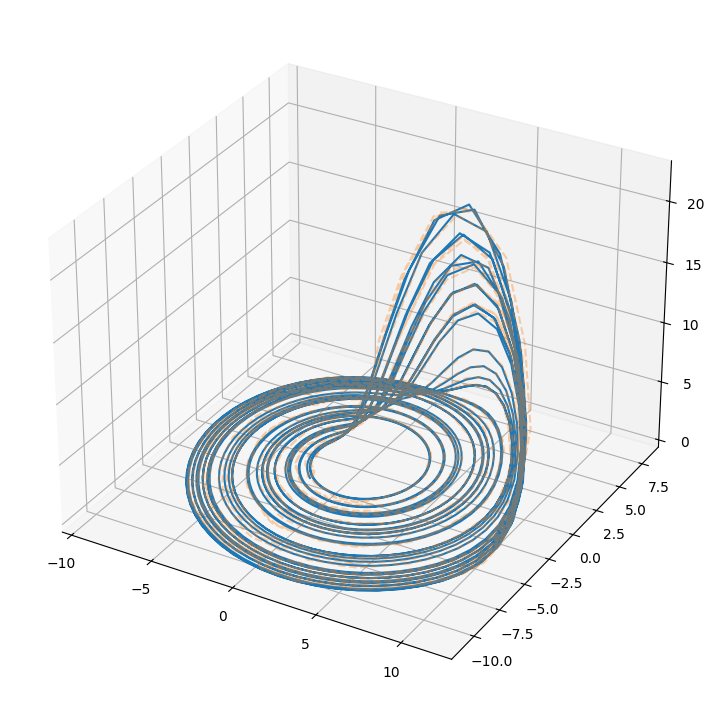

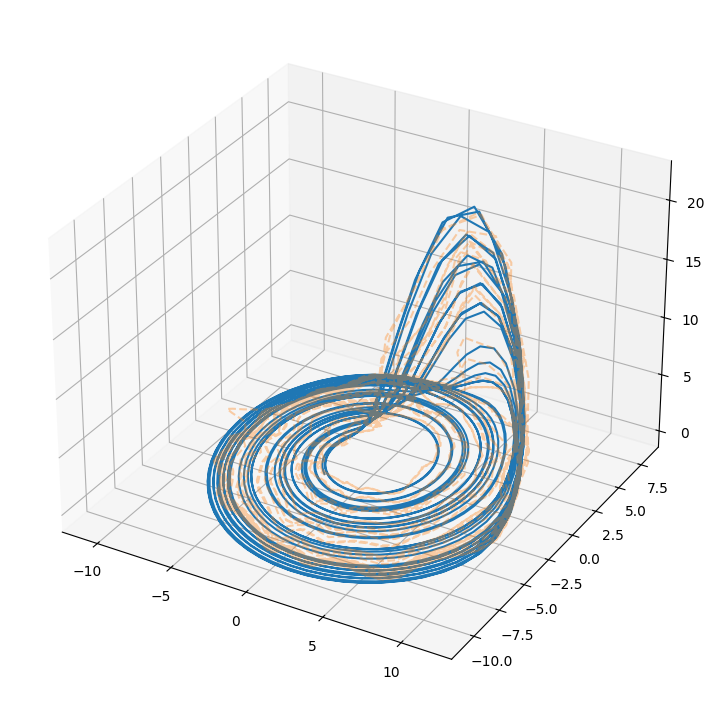

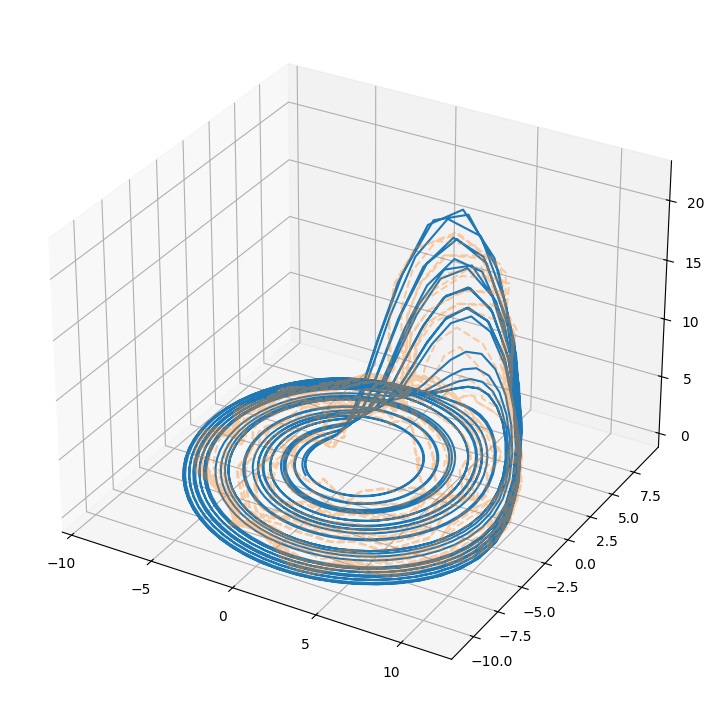

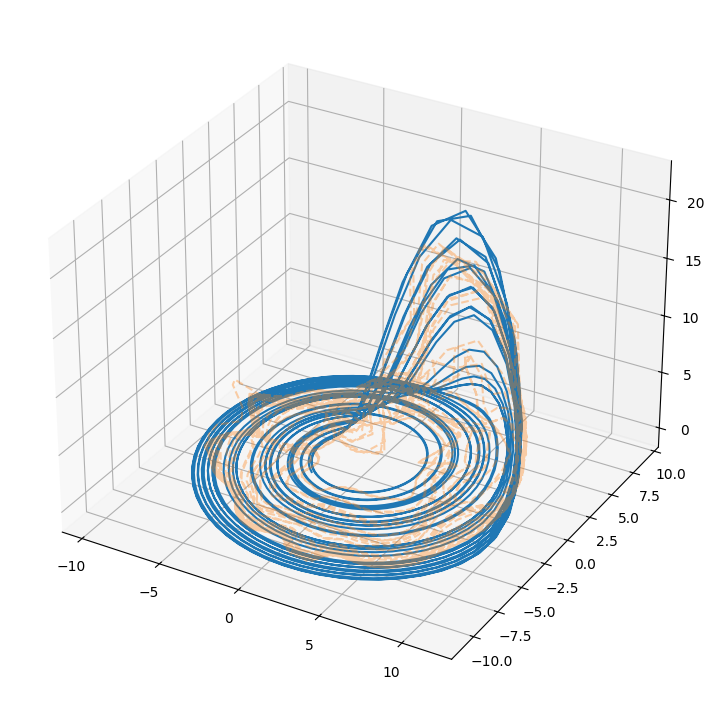

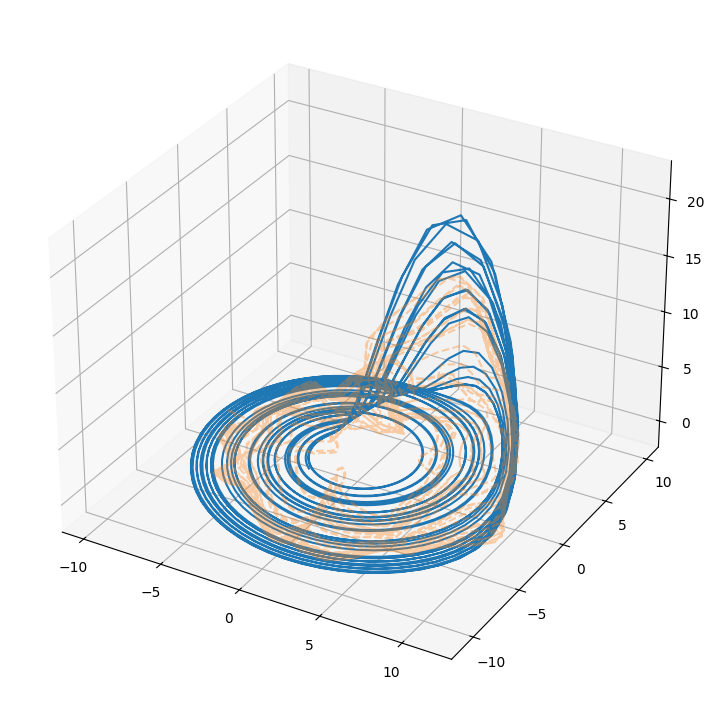

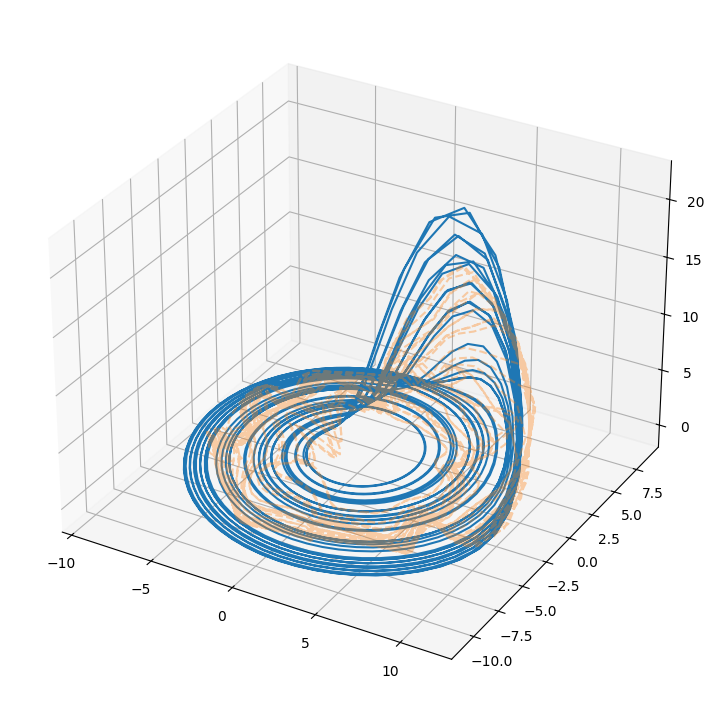

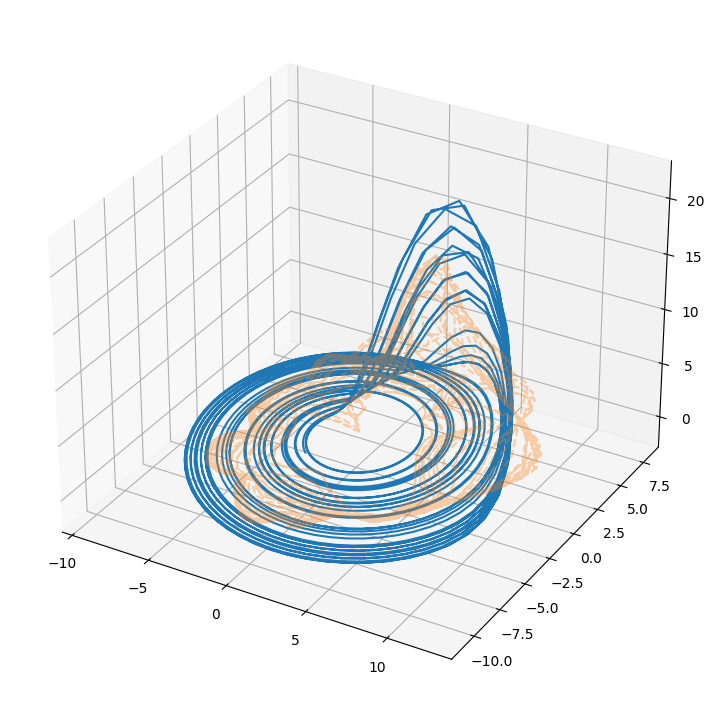

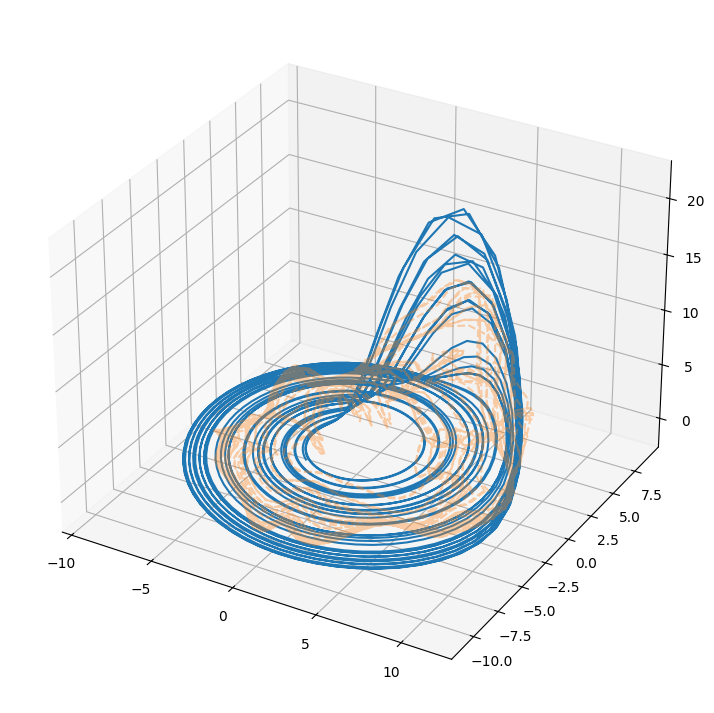

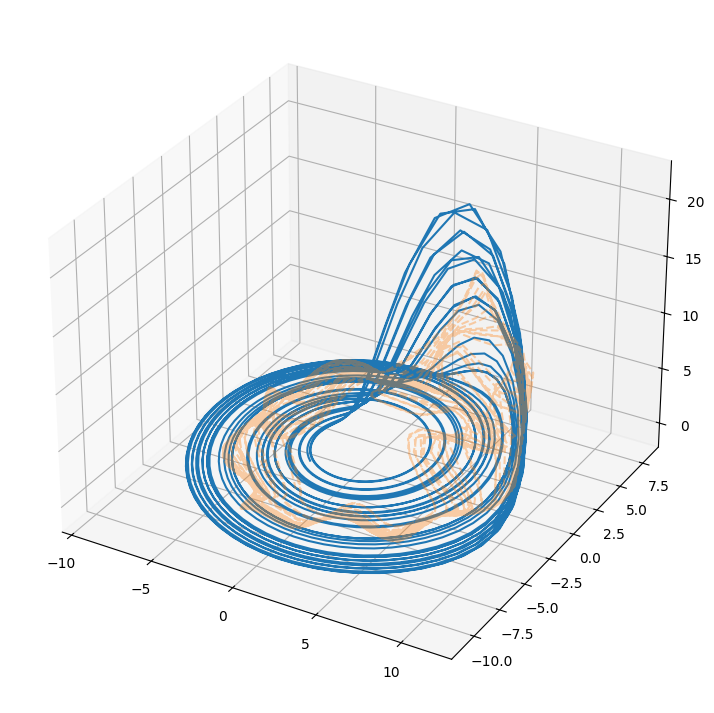

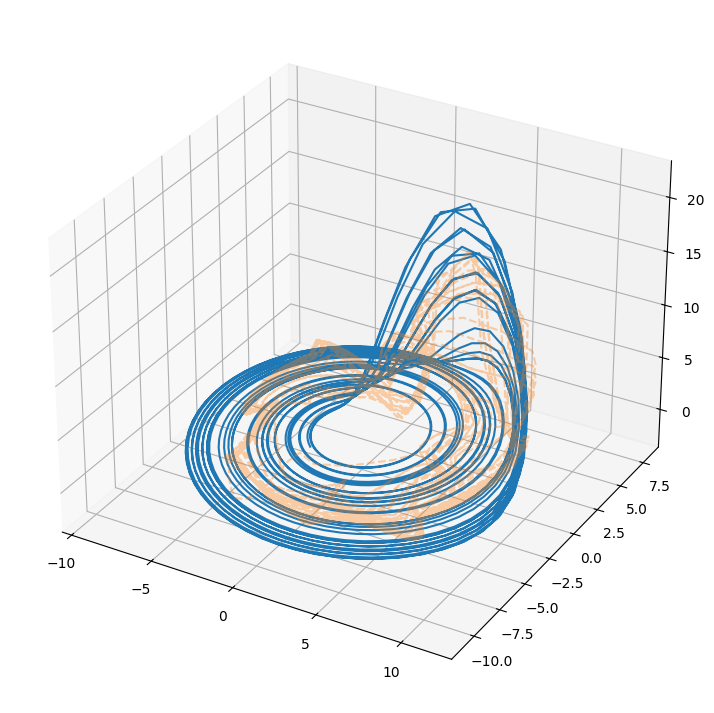

In [8]:
all_matrices = CalculateMatrices(train_parts, test_parts, plot_3d=True)

In [9]:
means, stds = CalculateMeanStd(all_matrices, frobenius=True)

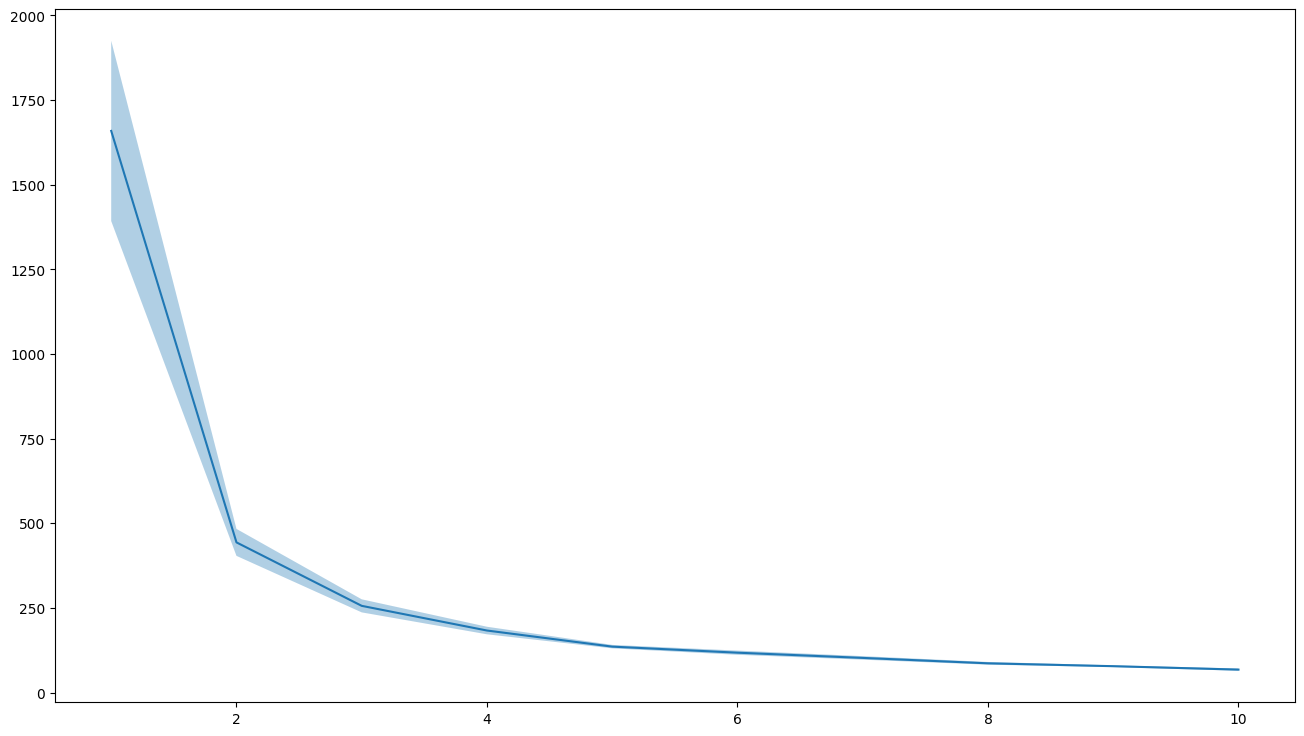

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(1, 11), means)
plt.fill_between(np.arange(1, 11), means - stds, means + stds, alpha=0.35)

# Library check

In [6]:
X_train = data[:20000, 1]
Y_train = data[1:20001, 1]

X_test = data[20001:30000, 1]
Y_test = data[20002:30001, 1]

In [25]:
reservoir = Reservoir(400, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7, input_bias=False)

states = reservoir.run(X_train[..., None])
readout.fit(states, Y_train[..., None], warmup=100)
            


Running Reservoir-7: 100%|██████████████████████████| 20000/20000 [00:01<00:00, 10314.55it/s]


'Ridge-7': Ridge(ridge=1e-07, input_bias=False, in=400, out=1)

In [26]:
states = reservoir.run(X_test[..., None])
output = readout.run(states)

Running Ridge-7: 100%|████████████████████████████████| 9999/9999 [00:00<00:00, 62885.50it/s]


In [27]:
readout.params

{'Wout': array([[-7.30407964e+01],
        [-4.75851350e+02],
        [-9.35373604e+01],
        [-9.44553727e+01],
        [-4.72399156e+02],
        [ 2.01287947e+02],
        [-8.16404169e+02],
        [ 3.44241579e+02],
        [ 7.77242019e+02],
        [ 1.59970651e+02],
        [-4.13216269e+02],
        [ 1.13446014e+02],
        [ 1.58575673e+02],
        [-4.02285343e+01],
        [ 4.72681342e+02],
        [-5.54078875e+01],
        [ 3.68532119e+02],
        [-3.67516866e+02],
        [-9.71796123e+00],
        [-3.36010867e+02],
        [-8.45292797e+01],
        [-3.56870898e+01],
        [ 4.24804180e+00],
        [-3.62770348e+02],
        [-2.33800257e+02],
        [-1.14366046e+02],
        [-1.69485282e+02],
        [ 2.11850254e+02],
        [ 5.16269938e+02],
        [-4.85257482e+01],
        [ 1.48087229e+02],
        [-3.62946814e+01],
        [-1.06822258e+03],
        [-8.59148742e+01],
        [-1.46351630e+02],
        [-1.06958333e+02],
        [ 4.60108869

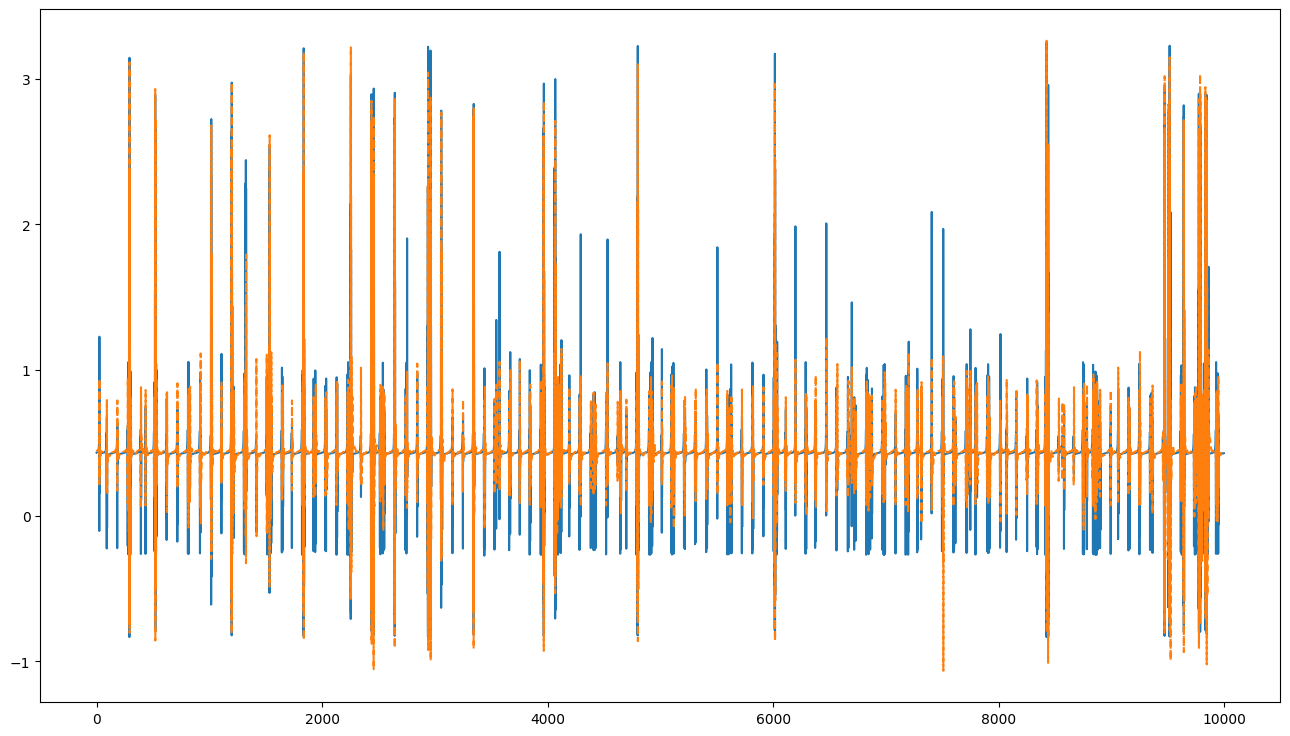

In [28]:
plt.figure(figsize=(16, 9))
plt.plot(Y_test)
plt.plot(output, linestyle = '--')
